# Plant Seedlings Classification

*Source*: Here's my solution for the Great Learning Project

In [1]:
# COLOR_BGR2RGB
color1 = 'BGR'
color2 = 'RGB'
chosen_metric = 'accuracy'

## Problem Statement

## Context
In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

## Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

## Data
### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

Importing necessary libraries

In [2]:
data_file_name = 'images.npy'
labels_file_name = 'Labels.csv'
data_dir = '../data'
image_dir = '../images'

In [3]:
%%writefile requirements0.txt
tensorflow
scikit-learn
seaborn
matplotlib
numpy
pandas
opencv-python

Overwriting requirements0.txt


In [4]:
import sys
from pathlib import Path

# In notebook
root_dir = Path().resolve().parents[1]  # Adjust if needed
sys.path.append(str(root_dir))

from utils import general

In [9]:
general.create_requirements_with_versions()

In [8]:
%%writefile requirements_google_colab.txt
matplotlib==3.7.1
numpy==1.25.2 
opencv-python==4.8.0.76
pandas==1.5.3 
scikit-learn==1.2.2
seaborn==0.13.1
tensorflow==2.15.0

Overwriting requirements_google_colab.txt


In [7]:
%%writefile requirements_jupyter.txt
matplotlib==3.3.4
numpy==1.24.3
opencv-python==4.8.0.76
pandas==1.5.2
scikit-learn==1.2.2
seaborn==0.11.1
tensorflow==2.13.0

Overwriting requirements_jupyter.txt


In [10]:
import seaborn as sns
sns.set_theme(style="white")
sns.set_context("talk")

In [13]:
import sys

if 'google.colab' in sys.modules:
    # We're in Google Colab
    # Importing cv2_imshow from google.patches to display images
    from google.colab.patches import cv2_imshow
    print("Running in Google Colab: cv2_imshow is available.")

In [14]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
import time

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV                                            
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
from sklearn import metrics
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [15]:
# Load the image file of dataset
images = np.load(f'{data_dir}/{data_file_name}')

# Load the labels file of dataset
labels = pd.read_csv(f'{data_dir}/{labels_file_name}')

In [16]:
images0 = images.copy()

## Data Overview

### Understand the shape of the dataset

In [17]:
print('images: ', images.shape)
print('labels: ', labels.shape)

images:  (4750, 128, 128, 3)
labels:  (4750, 1)


In [18]:
def modify_pixel_value(value):
  if int(value)==value:
    return f'{value:.0f}'
  else:
    return f'{value:.3f}'


def get_shape_images(dict_of_images):
  out = pd.DataFrame()
  for name, images_color in dict_of_images.items():
    images, color = images_color
    shape_df = pd.DataFrame(images.shape, columns=[name], index=['# Observations', 'Height', 'Width', '# Channels']).T
    shape_df['# Observations'] = shape_df['# Observations'].apply(lambda x: f'{x:,}')
    shape_df['Min'] = modify_pixel_value(images.min())
    shape_df['Max'] = modify_pixel_value(images.max())
    shape_df['Color'] = color
    out = pd.concat([out, shape_df])
  out.index.name = 'images'
  return out

In [19]:
display(get_shape_images({'Original': (images, color1)}))

# Observations  Height  Width  # Channels Min  Max Color
images                                                           
Original          4,750     128    128           3   0  255   BGR

In [20]:
labels['Label'].nunique()

12

## Exploratory Data Analysis

### Plotting random images from each of the class

In [21]:
def plot_images(images,labels, col='Label', titlesize = 14, figsize = (10, 8),
                modify_title=True, color=color1):
  num_classes=labels[col].nunique()                                              # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels[col])                                                      # Obtaing the unique classes from y_train
  rows = int(np.sqrt(num_classes))                                                # Defining number of rows=3
  cols = int(np.ceil(num_classes/rows))                                           # Defining number of columns=4
  fig = plt.figure(figsize=figsize)                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          title_text = keys[random_index]
          if modify_title:
            title_text = title_text.replace(' ', '\n')
          ax.set_title(title_text, fontsize = titlesize)
          sns.despine(ax=ax)
          ax.axis('off')
  plt.suptitle(f'Randomly Selected Images ({color})', fontsize=16)
  plt.savefig(f"{image_dir}/subplot_images_random_{color}.png", bbox_inches='tight')
  plt.show()

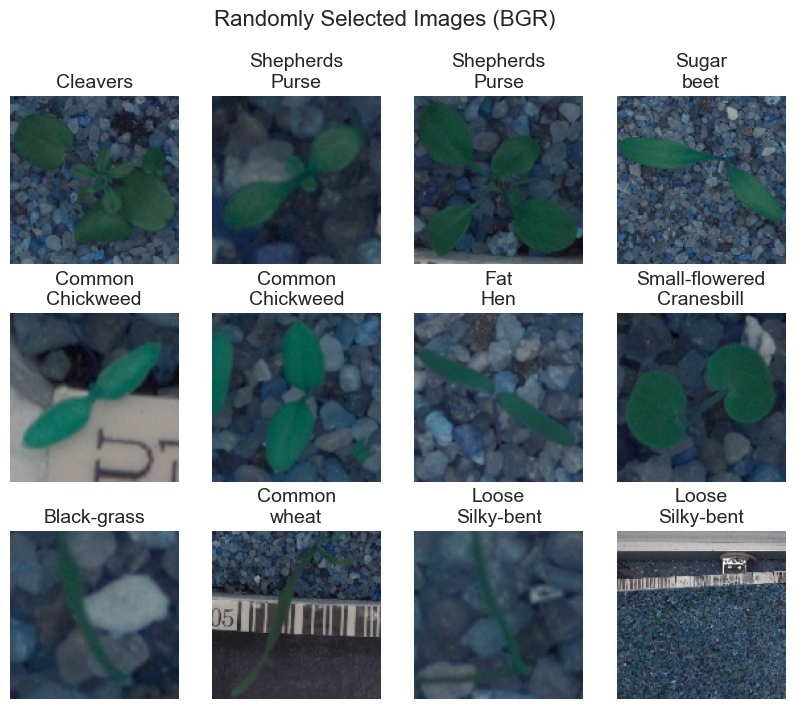

In [22]:
plot_images(images, labels)   # input the images and labels to the function and plot the images with their labels

In [23]:
def plot_images_each_class(images,labels, col='Label', titlesize = 14, figsize = (10, 8),
                modify_title=True, keep='first', txt='', color=color1):
  num_classes=labels[col].nunique()                                             # Number of Classes
  labels_unique = labels.drop_duplicates(subset=[col], keep=keep)
  categories=np.unique(labels)
  keys=dict(labels_unique[col])                                                      # Obtaing the unique classes from y_train
  rows = int(np.sqrt(num_classes))                                                # Defining number of rows=3
  cols = int(np.ceil(num_classes/rows))                                           # Defining number of columns=4
  fig = plt.figure(figsize=figsize)                                               # Defining the figure size to 10x8
  dimensions = (images[0].shape[0], images[0].shape[1])
  c = 0
  for i in range(cols):
      for j in range(rows):
          index = list(keys.keys())[c]                                                    # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[index, :])                                      # Plotting the image
          title_text = keys[index]
          if modify_title:
            title_text = title_text.replace(' ', '\n')
          ax.set_title(title_text, fontsize = titlesize)
          sns.despine(ax=ax)
          ax.axis('off')
          c += 1
  plt.suptitle(f'Images from Each Class ({color}, {dimensions[0]}x{dimensions[1]})', fontsize=16)
  plt.savefig(f"{image_dir}/subplot_images_{keep}_{color}_{dimensions[0]}x{dimensions[1]}.png", bbox_inches='tight')
  plt.show()

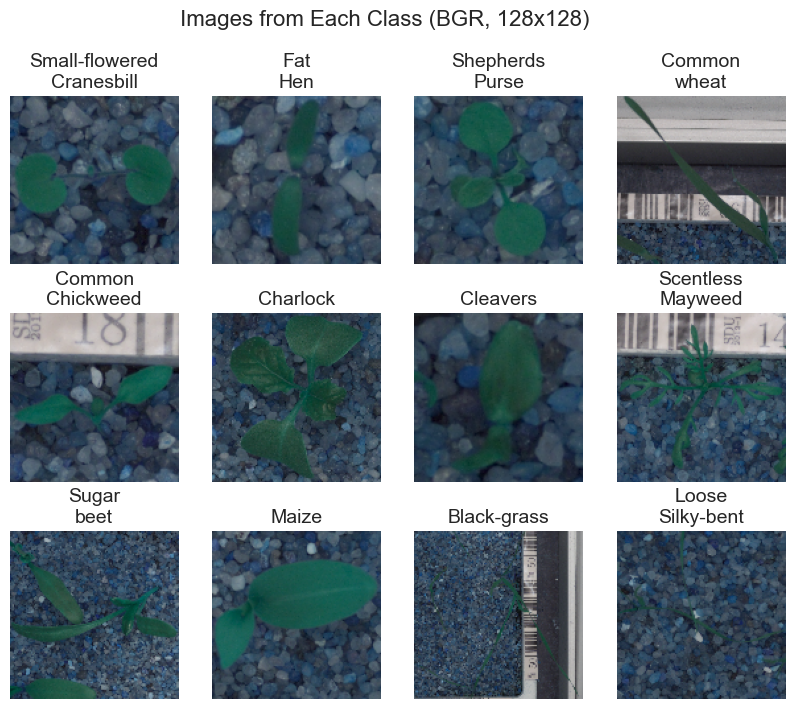

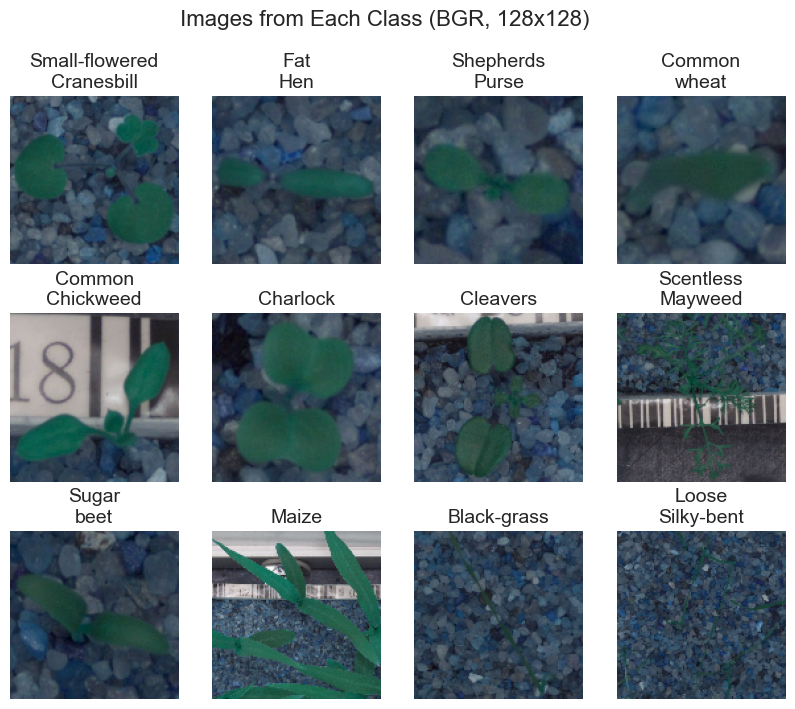

In [24]:
plot_images_each_class(images, labels, keep='first')
plot_images_each_class(images, labels, keep='last')

### Checking the distribution of the target variable

In [25]:
display(labels.head())
display(labels['Label'].value_counts())
display(100*labels['Label'].value_counts(normalize=True).round(2))

Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill

Label
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: count, dtype: int64

Label
Loose Silky-bent             14.0
Common Chickweed             13.0
Scentless Mayweed            11.0
Small-flowered Cranesbill    10.0
Fat Hen                      10.0
Charlock                      8.0
Sugar beet                    8.0
Cleavers                      6.0
Black-grass                   6.0
Shepherds Purse               5.0
Common wheat                  5.0
Maize                         5.0
Name: proportion, dtype: float64

In [26]:
def plot_target_distribution(labels, figsize=(10, 6), alpha=.7, col='Label'):
  num_classes=labels[col].nunique()
  plt.figure(figsize=figsize)
  # check for data imbalance
  sns.countplot(data = labels, y=col,
                order=labels[col].value_counts().index,
                hue = labels[col],
                palette=sns.color_palette("husl", num_classes),
                alpha=alpha,
                stat='percent')
  plt.xticks(rotation='horizontal');
  plt.tick_params(axis='y', length=0)
  plt.xlabel('%')
  plt.title('Target Distribution (in Percent)')
  plt.grid(axis='x', linestyle=':', alpha=alpha)
  sns.despine()
  plt.savefig(f"{image_dir}/target_distribution.png", bbox_inches='tight')

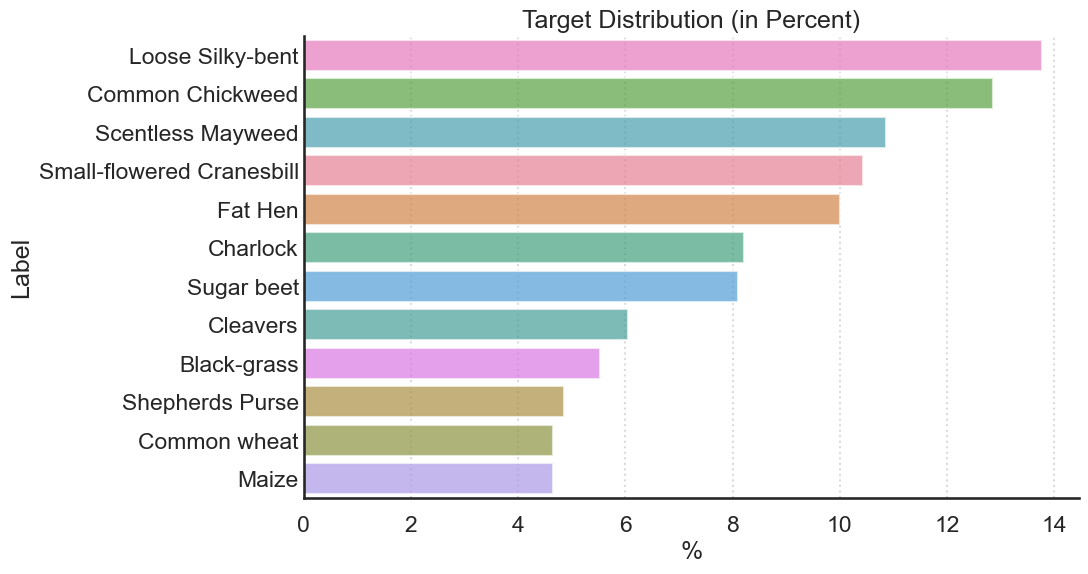

In [27]:
plot_target_distribution(labels)

## Data Pre-Processing

### Converting the BGR images to RGB images.

In [28]:
type(images)

numpy.ndarray

In [29]:
convert_single_image_BGR2RGB = lambda image: cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def convert_images_BGR2RGB(images):
  # Converting the images from BGR to RGB using cvtColor function of OpenCV
  return np.array(list(map(convert_single_image_BGR2RGB, images)))

In [30]:
cimages = convert_images_BGR2RGB(images)

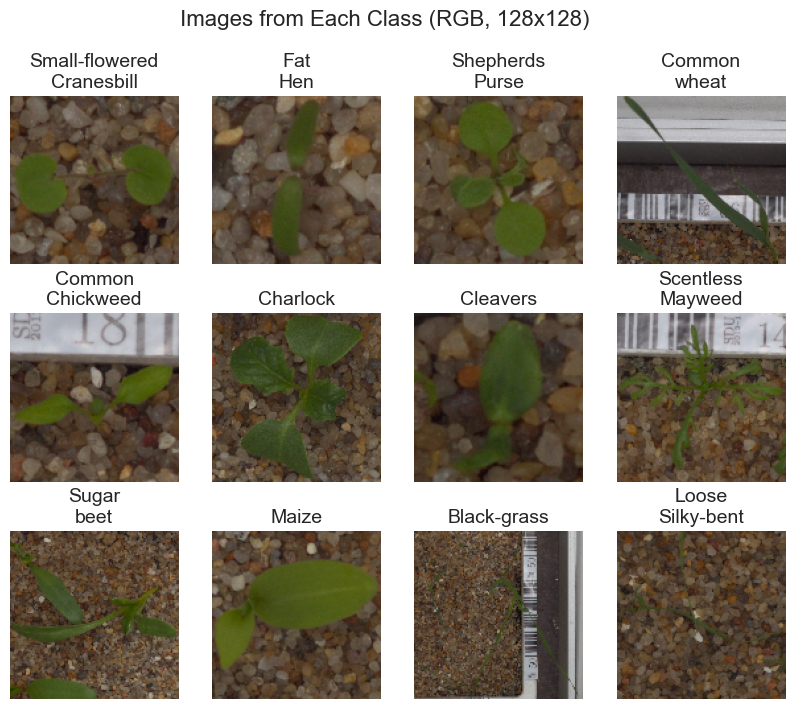

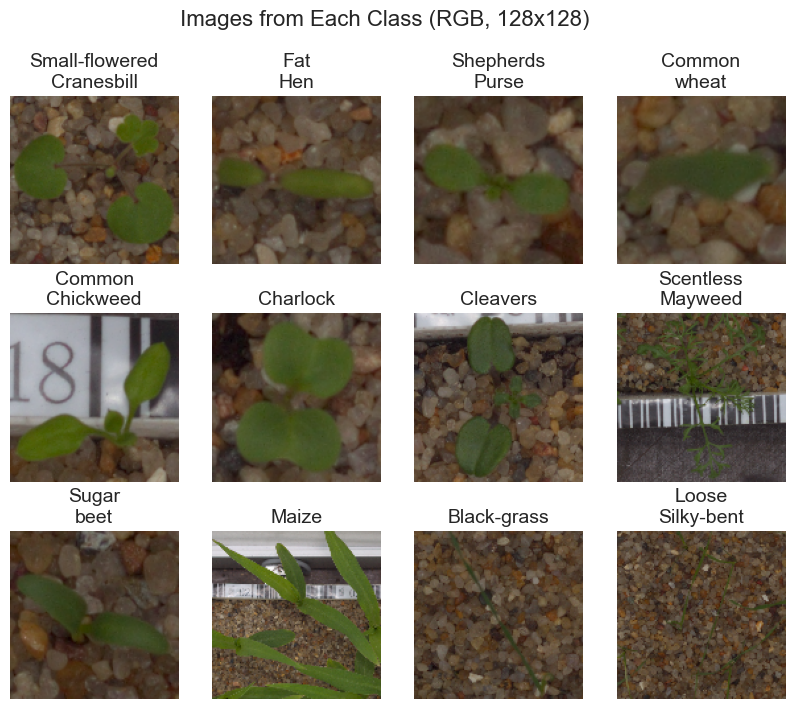

In [31]:
plot_images_each_class(cimages, labels, keep='first', color=color2)
plot_images_each_class(cimages, labels, keep='last', color=color2)

### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [32]:
def resize_single_image(image, dimensions):
  return cv2.resize(image, dimensions, interpolation=cv2.INTER_LINEAR)
def resize_images(images, height=64, width=64):
  current_height, current_width, nchannels = images[1].shape
  dimensions = (width, height)
  print(f'Resizing the image size from {current_height}x{current_width} to {height}x{width}.')
  return np.array([resize_single_image(image, dimensions) for image in images])

In [33]:
images_resized = resize_images(cimages, height=64, width=64)

Resizing the image size from 128x128 to 64x64.


In [34]:
images_resized.shape

(4750, 64, 64, 3)

In [35]:
dict_of_images = {
    'Original': (images, color1),
    'Converted Colors': (cimages, color2),
    'Resized': (images_resized, color2),
    'Normalized': (images_resized.astype('float32')/255.0, color2)
}
display(get_shape_images(dict_of_images))

# Observations  Height  Width  # Channels Min  Max Color
images                                                                   
Original                  4,750     128    128           3   0  255   BGR
Converted Colors          4,750     128    128           3   0  255   RGB
Resized                   4,750      64     64           3   0  255   RGB
Normalized                4,750      64     64           3   0    1   RGB

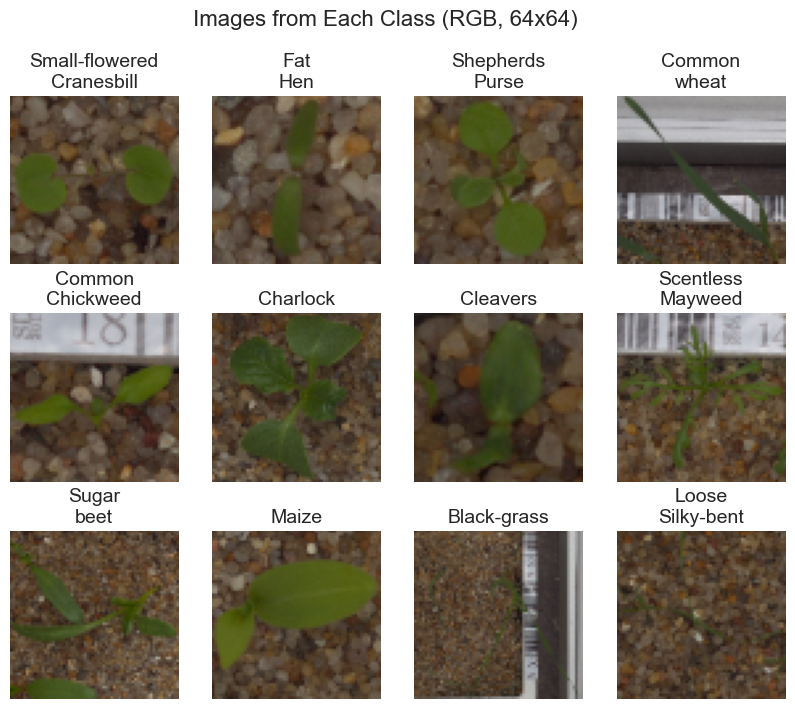

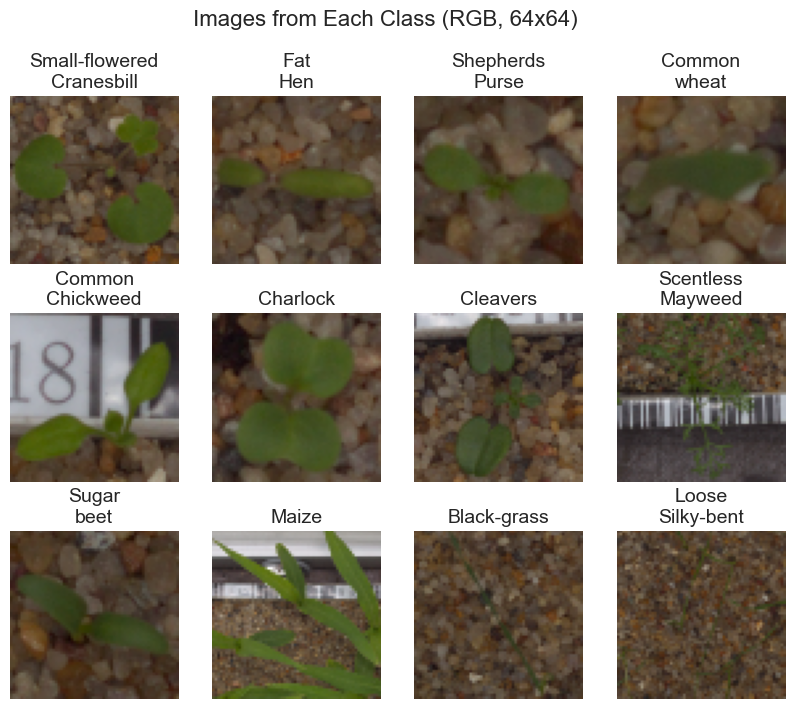

In [36]:
plot_images_each_class(images_resized, labels, keep='first', color=color2)
plot_images_each_class(images_resized, labels, keep='last', color=color2)

**Image before resizing**

In [37]:
labels

Label
0     Small-flowered Cranesbill
1     Small-flowered Cranesbill
2     Small-flowered Cranesbill
3     Small-flowered Cranesbill
4     Small-flowered Cranesbill
...                         ...
4745           Loose Silky-bent
4746           Loose Silky-bent
4747           Loose Silky-bent
4748           Loose Silky-bent
4749           Loose Silky-bent

[4750 rows x 1 columns]

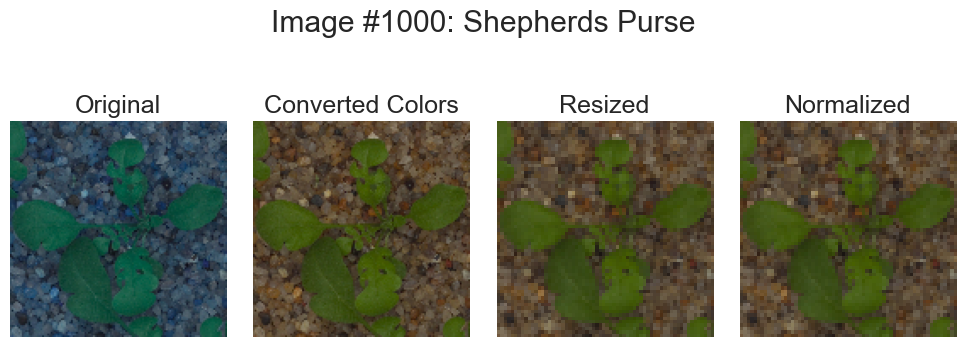

In [38]:
ind = 1000

fig, axes = plt.subplots(1, len(dict_of_images), figsize=(10, 4))

c = 0
for title, im_color in dict_of_images.items():
  im, color = im_color
  axes[c].imshow(im[ind, :])
  sns.despine(ax=axes[c])
  axes[c].axis('off')
  axes[c].set_title(title)
  c+=1


plt.suptitle(f"Image #{ind}: {labels.iloc[ind]['Label']}")
plt.tight_layout()
plt.savefig(f"{image_dir}/image_{ind}_preprocessed.png", bbox_inches='tight')
plt.show()


**Image after resizing**

### Data Preparation for Modeling


- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [39]:
def get_model_num_params(model):

  # Extract values
  total_params = model.count_params()
  trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
  non_trainable_params = np.sum([np.prod(w.shape) for w in model.non_trainable_weights])

  # Now you can use them programmatically
  print("Total:", total_params)
  print("Trainable:", trainable_params)
  print("Non-trainable:", non_trainable_params)

In [40]:
X = images_resized
y = labels
rs = 42

In [41]:
# split the data with test_size as 0.1
X_temp, X_test, y_temp, y_test = train_test_split(
                                        X,
                                        y,
                                        test_size=.1,
                                        random_state=rs,
                                        stratify=y
                                        )
# split the data with test_size as 0.1
X_train, X_val, y_train, y_val = train_test_split(
                                            X_temp,
                                            y_temp,
                                            test_size=1-(8/9),
                                            random_state=rs,
                                            stratify=y_temp
                                            )

In [42]:
# check the shape of train, validation and test data
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)
print(X_test.shape[0]/X.shape[0])
print(X_val.shape[0]/X.shape[0])

(3799, 64, 64, 3) (3799, 1)
(476, 64, 64, 3) (476, 1)
(475, 64, 64, 3) (475, 1)
0.1
0.10021052631578947


In [43]:
dict_of_images = {
    'Original': (images, color1),
    'Converted Colors': (cimages, color2),
    'Resized': (images_resized, color2),
    'Train': (X_train, color2),
    'Validation': (X_val, color2),
    'Test': (X_test, color2)
}
display(get_shape_images(dict_of_images))

# Observations  Height  Width  # Channels Min  Max Color
images                                                                   
Original                  4,750     128    128           3   0  255   BGR
Converted Colors          4,750     128    128           3   0  255   RGB
Resized                   4,750      64     64           3   0  255   RGB
Train                     3,799      64     64           3   0  255   RGB
Validation                  476      64     64           3   0  254   RGB
Test                        475      64     64           3   0  255   RGB

### Encoding the target labels

In [44]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

enc = LabelBinarizer()                                        # intialize the labelBinarizer
y_train_encoded = enc.fit_transform(y_train)         # fit and transform y_train
y_val_encoded=enc.transform(y_val)                 # transform y_val
y_test_encoded=enc.transform(y_test)                # transform y_test

In [45]:
y_train_encoded.shape,y_val_encoded.shape,y_test_encoded.shape    # check the shape of train, validation and test data

((3799, 12), (476, 12), (475, 12))

In [46]:
def get_shape_target(dict_of_y):
  out = pd.DataFrame()
  for name, d in dict_of_y.items():
    shape_df = pd.DataFrame(d.shape, columns=[name], index=['# Rows', '# Columns']).T
    shape_df['# Rows'] = shape_df['# Rows'].apply(lambda x: f'{x:,}')
    out = pd.concat([out, shape_df])
  out.index.name = 'target'
  return out

In [47]:
dict_of_y = {
    'Original': y,
    'Train': y_train,
    'Train (Encoded)': y_train_encoded,
    'Validation': y_val,
    'Validation (Encoded)': y_val_encoded,
    'Test': y_test,
    'Test (Encoded)': y_test_encoded,
}
display(get_shape_target(dict_of_y))

# Rows  # Columns
target                                
Original              4,750          1
Train                 3,799          1
Train (Encoded)       3,799         12
Validation              476          1
Validation (Encoded)    476         12
Test                    475          1
Test (Encoded)          475         12

### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [48]:
# Complete the code to normalize the image pixels of train, test and validation data
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [49]:
dict_of_images = {
    'Original': (images, color1),
    'Converted Colors': (cimages, color2),
    'Resized': (images_resized, color2),
    'Train': (X_train, color2),
    'Train (Normalized)': (X_train_normalized, color2),
    'Validation': (X_val, color2),
    'Validation (Normalized)': (X_val_normalized, color2),
    'Test': (X_test, color2),
    'Test (Normalized)': (X_test_normalized, color2),
}
display(get_shape_images(dict_of_images))

# Observations  Height  Width  # Channels Min    Max  \
images                                                                         
Original                         4,750     128    128           3   0    255   
Converted Colors                 4,750     128    128           3   0    255   
Resized                          4,750      64     64           3   0    255   
Train                            3,799      64     64           3   0    255   
Train (Normalized)               3,799      64     64           3   0      1   
Validation                         476      64     64           3   0    254   
Validation (Normalized)            476      64     64           3   0  0.996   
Test                               475      64     64           3   0    255   
Test (Normalized)                  475      64     64           3   0      1   

                        Color  
images                         
Original                  BGR  
Converted Colors          RGB  
Resized                   RGB  
Train                     RGB  
Train (Normalized)        RGB  
Validation                RGB  
Validation (Normalized)   RGB  
Test                      RGB  
Test (Normalized)         RGB

## Model Building

In [50]:
# Clearing backend
backend.clear_session()

In [51]:
# Fixing the seed for random number generators
np.random.seed(rs)
random.seed(rs)
tf.random.set_seed(rs)

In [52]:
input_shape = X[0].shape
print(f'Input shape is {input_shape}.')

Input shape is (64, 64, 3).


In [53]:
# Intializing a sequential model
model1 = Sequential()

# add the first conv layer with 128 filters
# and kernel size 3x3
# padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(input_shape)))

# add the max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# flatten the output of the conv layer after max pooling
# to make it ready for creating dense connections
model1.add(Flatten())

# add a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))
# add the output layer with 12 neurons
# and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# use the Adam Optimizer
opt = Adam()
# Compile the model using suitable metric for loss fucntion
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# generate the summary of the model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        32,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,828 (503.23 KB)

 Trainable params: 128,828 (503.23 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
get_model_num_params(model1)

Total: 128828
Trainable: 128828
Non-trainable: 0.0


In [55]:
import re

def strip_suffix(name):
    name = re.sub(r'_\d+$', '', name)
    name = name.replace('2d', '')
    name = name.replace('_', ' ')
    return name

In [56]:
[strip_suffix(l.name) for l in model1.layers]

['conv',
 'max pooling',
 'conv',
 'max pooling',
 'conv',
 'max pooling',
 'flatten',
 'dense',
 'dropout',
 'dense']

<b> Fitting the model on the train data

In [57]:



# Complete the code to fit the model on train and also using the validation data for validation
def training(model, xtrain, ytrain, xval, yval, batch_size=32, epochs=30,
             to_augment = False, datagen = None, callback=None):
  rotation = 0
  start = time.time()
  if datagen == None:
    history = model.fit(
              xtrain, ytrain,
              epochs=epochs,
              validation_data=(xval, yval),
              batch_size=batch_size,
              verbose=2
    )
  else:
    to_augment = True
    generator = train_datagen.flow(xtrain, ytrain,
                                       batch_size=batch_size,
                                       shuffle=False)
    try:
      rotation = generator.image_data_generator.rotation_range
    except:
      pass
    steps_per_epoch = xtrain.shape[0] // batch_size
    history = model.fit(generator,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=(xval, yval),
                        verbose=1,
                        callbacks=[callback])
  end=time.time()
  elapsed_time = end - start

  lr_name = ''
  if callback != None:
    try:
      lr = callback
      lr_name = lr.__class__.__name__ #Learning Rate Reduction
      #lr.min_lr, lr.patience, lr.factor
    except Exception as e:
      print(e)

  tinfo = {
      'Batch Size': batch_size
      ,'Elapsed Time (s)': round(elapsed_time, 2)
      ,'Augmentation (Rotation)': rotation
      ,'Learning Rate Reduction': lr_name
  }
  return history, tinfo


def get_model_params(model, history, tinfo = {}, chosen_metric=chosen_metric):
  optimizer_params = model.optimizer.get_config()
  learning_rate = optimizer_params.get('learning_rate', '-')
  momentum = str(optimizer_params.get('momentum', '-'))
  optimizer_name = optimizer_params.get('name')
  layers = model.layers
  info = {}
  dense_layers = [layer for layer in layers if isinstance(layer, Dense)]
  dropout_layers = [l for l in layers if isinstance(l, Dropout)]
  conv2d_layers = [l for l in layers if isinstance(l, Conv2D)]
  maxpooling2d_layers = [l for l in layers if isinstance(l, MaxPooling2D)]
  BatchNormalization_layers = [l for l in layers if isinstance(l, BatchNormalization)]
  dropout_configs = [l.get_config() for l in dropout_layers]
  regularization = [f"Dropout({c['rate']})" for c in dropout_configs]
  if len(layers)>1:
    hidden_layers = layers[:-1]

  layer_names = [strip_suffix(l.name) for l in layers]
  normalization_layer_names = [strip_suffix(l.name) for l in BatchNormalization_layers]
  activation_conv2d = list(map(lambda l: l.activation.__name__, conv2d_layers))
  activation_dense = list(map(lambda l: l.activation.__name__, dense_layers))
  num_filters = list(map(lambda l: l.filters, conv2d_layers))
  num_neurons = list(map(lambda l: l.units, dense_layers))
  num_trainable_params = f'{int(np.sum([np.prod(w.shape) for w in model.trainable_weights])):,}'
  steps = history.params['steps'] #steps per epoch
  epochs = history.params['epochs']


  info.update({
      'Layers': ', '.join(layer_names)
      ,'# Trainable Params': num_trainable_params
      ,'Epochs': epochs
      ,'Batch Size': None
      ,'Augmentation (Rotation)': None
      ,'Learning Rate Reduction': ''
      ,'Steps per Epoch': steps
      ,"# Conv2D Layers": len(conv2d_layers)
      ,"# MaxPooling2D Layers": len(maxpooling2d_layers)
      ,"# Dropout Layers": len(dropout_layers)
      ,"Normalization Layer": ', '.join(normalization_layer_names)
      ,"# Neurons (Dense)": ', '.join(map(str, num_neurons))
      ,"# Filters (Conv)": ', '.join(map(str, num_filters))
      ,"Activation (Dense)": ', '.join(activation_dense)
      ,"Activation (Conv)": ', '.join(activation_conv2d)
      ,'Optimizer': optimizer_name
      ,'Learning Rate': round(learning_rate, 4)
      ,'Regularization': ', '.join(regularization)
      ,'Train Loss': round(history.history["loss"][-1], 4)
      ,'Validation Loss': round(history.history["val_loss"][-1], 4)
      ,f'Train {chosen_metric.title()}': round(history.history[chosen_metric][-1], 3)
      ,f'Validation {chosen_metric.title()}': round(history.history[f"val_{chosen_metric}"][-1], 3)
      ,'Test Loss': None
      ,f'Test {chosen_metric.title()}': None
      ,'Elapsed Time (s)': None
      })

  info.update(tinfo)
  return info

In [58]:
%%capture
history1, tinfo1 = training(model1, X_train_normalized, y_train_encoded,
         X_val_normalized, y_val_encoded,
         batch_size=32, epochs=30)


In [59]:
info1 = get_model_params(model1, history1, tinfo1)
# evaluate the model on test data
test_loss, test_accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)
info1.update({'Test Loss': round(test_loss, 3), 'Test Accuracy': round(test_accuracy, 3)})

15/15 - 0s - 15ms/step - accuracy: 0.6905 - loss: 1.0905


In [60]:
info1

{'Layers': 'conv, max pooling, conv, max pooling, conv, max pooling, flatten, dense, dropout, dense',
 '# Trainable Params': '128,828',
 'Epochs': 30,
 'Batch Size': 32,
 'Augmentation (Rotation)': 0,
 'Learning Rate Reduction': '',
 'Steps per Epoch': 119,
 '# Conv2D Layers': 3,
 '# MaxPooling2D Layers': 3,
 '# Dropout Layers': 1,
 'Normalization Layer': '',
 '# Neurons (Dense)': '16, 12',
 '# Filters (Conv)': '128, 64, 32',
 'Activation (Dense)': 'relu, softmax',
 'Activation (Conv)': 'relu, relu, relu',
 'Optimizer': 'adam',
 'Learning Rate': 0.001,
 'Regularization': 'Dropout(0.3)',
 'Train Loss': 0.9925,
 'Validation Loss': 1.0425,
 'Train Accuracy': 0.634,
 'Validation Accuracy': 0.702,
 'Test Loss': 1.091,
 'Test Accuracy': 0.691,
 'Elapsed Time (s)': 163.73}

**Model Evaluation**

In [61]:
def plot_history(history, metric='accuracy', name1 = 'loss', model_name=''):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7, 8)) #Creating a subplot with figure and axes.
    axes[0].plot(history.history[name1], label='Train') #Plotting the train accuracy or train loss
    axes[0].plot(history.history['val_'+name1], label='Validation') #Plotting the validation accuracy or validation loss
    title = name1.replace('_', ' ').title()
    axes[0].set_title(f'Model {model_name} - {name1.title()} & {metric.title()}')
    axes[0].set_ylabel(name1.title())
    axes[0].legend(frameon=False)
    axes[0].grid(True, linestyle=':')
    sns.despine(ax=axes[0], top=True, right=True)

    axes[1].plot(history.history[metric], label='Train') #Plotting the train accuracy or train loss
    axes[1].plot(history.history['val_'+metric], label='Validation') #Plotting the validation accuracy or validation loss
    title = metric.replace('_', ' ').title()
    axes[1].set_ylabel(metric.title())
    axes[1].set_xlabel('Epoch')
    axes[1].grid(True, linestyle=':')
    sns.despine(ax=axes[1], top=True, right=True)
    axes[1].legend().remove()
    plt.tight_layout()

    plt.savefig(f"{image_dir}/model_{model_name}_{name1}_{metric}.png", bbox_inches='tight');

In [62]:
def plot_history_metric(history, metric='accuracy'):
  plt.plot(history.history[metric])
  plt.plot(history.history[f'val_accuracy'])
  plt.title(f'Model {metric.capitalize()}')
  plt.ylabel(metric.capitalize())
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.legend(frameon=False)
  sns.despine(top=True, right=True)
  plt.grid(True, linestyle=':')
  plt.show()

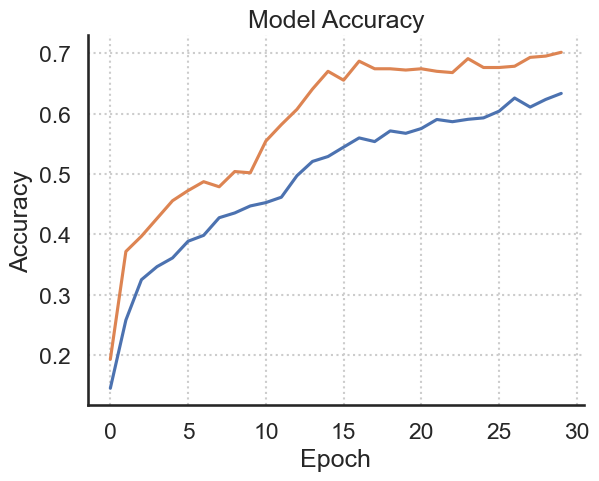

In [63]:
plot_history_metric(history1, metric=chosen_metric)

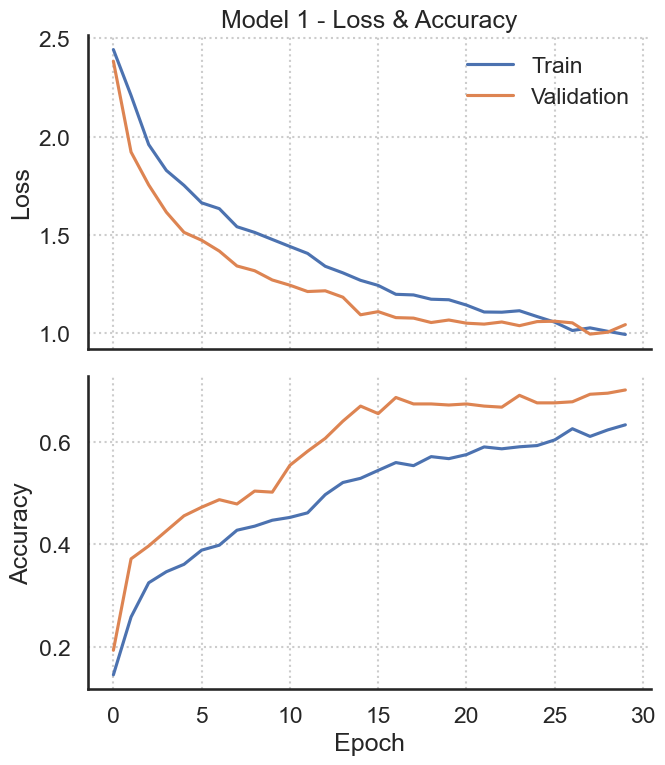

In [64]:
plot_history(history1, metric=chosen_metric, name1 = 'loss', model_name='1')

**Evaluate the model on test data**

In [65]:
loss, accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)    # evaluate the model on test data

15/15 - 0s - 14ms/step - accuracy: 0.6905 - loss: 1.0905


**Plotting the Confusion Matrix**

In [66]:
# Here we would get the output as probablities for each category
# predict the output probabilities
y_test_pred_encoded = model1.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [67]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_test_pred_encoded, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)

In [68]:
from pprint import pprint

In [69]:
def plot_confusion_matrix(y_true, y_pred, title='', figsize=(8,8), model_name=''):
  # Plotting the Confusion Matrix using confusion matrix() function
  # which is also predefined in tensorflow module
  # plot the confusion matrix
  confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
  f, ax = plt.subplots(figsize=figsize)

  shrink = .75
  sns.heatmap(
      confusion_matrix,
      cbar = True,
      cbar_kws={'shrink':shrink, 'pad':0},
      annot=True,
      linewidths=.4,
      fmt="d",
      square=True,
      ax=ax
  )
  # Setting the labels to both the axes
  ax.set_xlabel('Predicted Labels');ax.set_ylabel('True labels');
  ax.set_title(f'Confusion Matrix\nModel {model_name}');
  ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
  ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
  plt.tight_layout()
  plt.savefig(f"{image_dir}/model_{model_name}_confusion_matrix.png", bbox_inches='tight')
  plt.show()


def plot_confusion_matrix(y_true, y_pred, title='', figsize=(10, 10), model_name='', normalize=False):
  # Plotting the Confusion Matrix using confusion matrix() function
  # which is also predefined in tensorflow module
  # plot the confusion matrix
  extra_text = ''
  confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
  f, ax = plt.subplots(figsize=figsize)

  cm = confusion_matrix
  fmt = "d"
  fontsize = 12
  extra_title = ''

  if normalize:
    cm = confusion_matrix/np.sum(confusion_matrix, axis=1)
    extra_text = '_Normalized'
    fmt = ".0%"
    fontsize = 12
    extra_title = ' (%)'


  shrink = .75
  sns.heatmap(
      cm,
      cbar = True,
      cbar_kws={'shrink':shrink, 'pad':0},
      annot_kws={"size": fontsize},
      annot=True,
      linewidths=.4,
      fmt=fmt,
      square=True,
      ax=ax
  )
  # Setting the labels to both the axes
  ax.set_xlabel('Predicted Labels');ax.set_ylabel('True labels');
  ax.set_title(f'Confusion Matrix - Test Data\nModel {model_name}{extra_title}');
  ax.xaxis.set_ticklabels(list(enc.classes_),rotation=90)
  ax.yaxis.set_ticklabels(list(enc.classes_),rotation=0)
  plt.tight_layout()
  plt.savefig(f"{image_dir}/model_{model_name}_confusion_matrix{extra_text}.png", bbox_inches='tight')
  plt.show()





def add_empty_row_above(df, target_index):
  # Create an empty row (with NaNs, same columns)
  empty_row = pd.DataFrame([['']*df.shape[1]], columns=df.columns, index=[''])
  empty_rows = pd.concat([empty_row]*3)

  # Get position of the target index
  pos = df.index.get_loc(target_index)
  # Insert the empty row
  df_new = pd.concat([df.iloc[:pos], empty_rows, df.iloc[pos:]])
  return df_new

def add_merged_row_above(df, target_index, index, value):
  # Create a "merged" display row (visually simulated)
  empty_row = pd.DataFrame([['']*df.shape[1]], columns=df.columns, index=[''])
  merge_row = pd.DataFrame([['', '', value, '']], columns=df.columns, index=[index])
  empty_rows = pd.concat([empty_row]*3)
  added_rows = pd.concat([empty_rows, merge_row])


  pos = df.index.get_loc(target_index)
  df_new = pd.concat([df.iloc[:pos], added_rows, df.iloc[pos:]])
  return df_new



def show_classification_report(y_true, y_pred, model_name=''):
  report_str = metrics.classification_report(y_true, y_pred, target_names=list(enc.classes_))
  report_dict = metrics.classification_report(y_true, y_pred, output_dict=True, target_names=list(enc.classes_))
  # print('\t'*6 + f'Model {model_name}\n', report_str)
  accuracy = report_dict.pop("accuracy")
  # Convert the rest to a DataFrame
  report_df = pd.DataFrame(report_dict).transpose()
  report_df['support'] = report_df['support'].astype(int)
  for col in ['precision', 'recall', 'f1-score']:
    report_df[col] = report_df[col].map(lambda x: f"{x:.3f}")

  sub_report_df = report_df.iloc[:len(enc.classes_)]
  sub_report_df = sub_report_df.astype(float)
  sub_report_df.index.name = 'Categories'

  report_df = add_merged_row_above(report_df, 'macro avg', 'accuracy', f'{accuracy:.3f}')
  report_df.columns = pd.MultiIndex.from_product([[f'Classification Report (Test Data) - Model {model_name}'], report_df.columns])

  display(report_df)
  return sub_report_df



15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


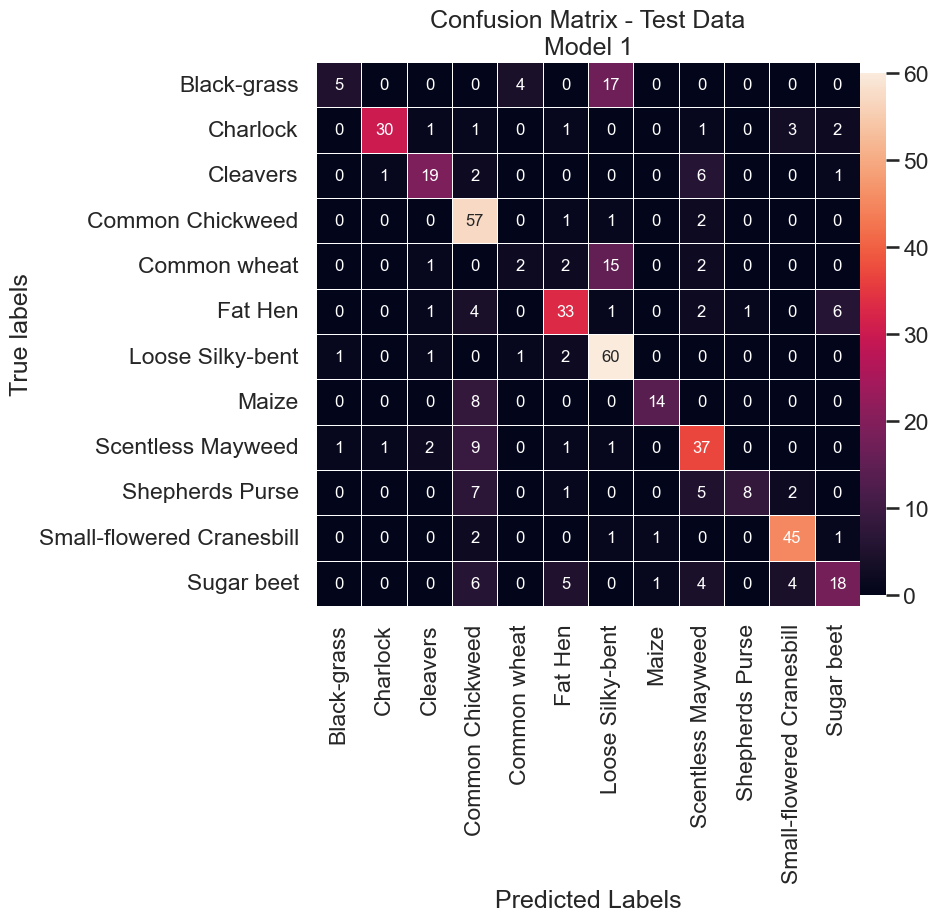

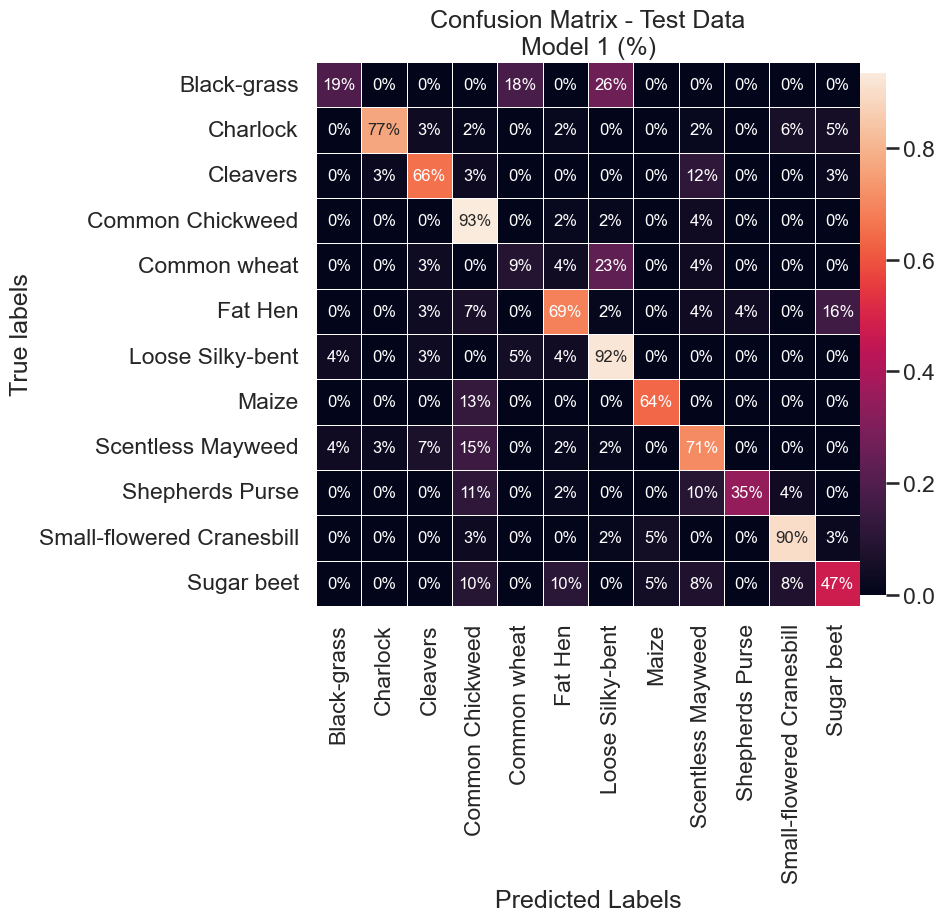

Classification Report (Test Data) - Model 1         \
                                                            precision recall   
Black-grass                                                     0.714  0.192   
Charlock                                                        0.938  0.769   
Cleavers                                                        0.760  0.655   
Common Chickweed                                                0.594  0.934   
Common wheat                                                    0.286  0.091   
Fat Hen                                                         0.717  0.688   
Loose Silky-bent                                                0.625  0.923   
Maize                                                           0.875  0.636   
Scentless Mayweed                                               0.627  0.712   
Shepherds Purse                                                 0.889  0.348   
Small-flowered Cranesbill                                       0.833  0.900   
Sugar beet                                                      0.643  0.474   
                                                                               
                                                                               
                                                                               
accuracy                                                                       
macro avg                                                       0.708  0.610   
weighted avg                                                    0.701  0.691   

                                            
                          f1-score support  
Black-grass                  0.303      26  
Charlock                     0.845      39  
Cleavers                     0.704      29  
Common Chickweed             0.726      61  
Common wheat                 0.138      22  
Fat Hen                      0.702      48  
Loose Silky-bent             0.745      65  
Maize                        0.737      22  
Scentless Mayweed            0.667      52  
Shepherds Purse              0.500      23  
Small-flowered Cranesbill    0.865      50  
Sugar beet                   0.545      38  
                                            
                                            
                                            
accuracy                     0.691          
macro avg                    0.623     475  
weighted avg                 0.668     475

In [70]:
y_test_pred_encoded = model1.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_test_pred_encoded, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)
plot_confusion_matrix(y_test_arg, y_pred_arg, model_name='1')
plot_confusion_matrix(y_test_arg, y_pred_arg, model_name='1', normalize=True)
report_df1 = show_classification_report(y_test_arg, y_pred_arg, model_name='1')

**Plotting Classification Report**

## Model Performance Improvement

**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [71]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


### **Data Augmentation**

In [72]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(rs)
random.seed(rs)
tf.random.set_seed(rs)

In [73]:
# Complete the code to set the rotation_range to 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [74]:
# Intializing a sequential model
model2 = Sequential()

# add the first conv layer with 64 filters
# and kernel size 3x3 ,
# padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(filters = 64, kernel_size = (3,3), activation='relu', padding="same", input_shape=input_shape))

# add max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D(pool_size = (2, 2), padding = 'same'))


model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# add dropout with dropout_rate=0.3
model2.add(Dropout(0.3))
# add the output layer with 12 neurons
# and activation functions as softmax (multi-class classification problem)
model2.add(Dense(12, activation='softmax'))

# initialize Adam Optimimzer
opt=Adam()
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       131,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,676 (592.48 KB)

 Trainable params: 151,612 (592.23 KB)

 Non-trainable params: 64 (256.00 B)

<b> Fitting the model on the train data

In [75]:
%%capture
history2, tinfo2 = training(model2, X_train_normalized,y_train_encoded,
                              X_val_normalized,y_val_encoded, batch_size=64, epochs=30,
             to_augment = True, datagen = train_datagen, callback=learning_rate_reduction)

In [76]:
info2 = get_model_params(model2, history2, tinfo2)
# evaluate the model on test data
test_loss, test_accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)
info2.update({'Test Loss': round(test_loss, 3), 'Test Accuracy': round(test_accuracy, 3)})
info2

15/15 - 0s - 8ms/step - accuracy: 0.6905 - loss: 0.9258


{'Layers': 'conv, max pooling, conv, max pooling, batch normalization, flatten, dense, dropout, dense',
 '# Trainable Params': '151,612',
 'Epochs': 30,
 'Batch Size': 64,
 'Augmentation (Rotation)': 20,
 'Learning Rate Reduction': 'ReduceLROnPlateau',
 'Steps per Epoch': 59,
 '# Conv2D Layers': 2,
 '# MaxPooling2D Layers': 2,
 '# Dropout Layers': 1,
 'Normalization Layer': 'batch normalization',
 '# Neurons (Dense)': '16, 12',
 '# Filters (Conv)': '64, 32',
 'Activation (Dense)': 'relu, softmax',
 'Activation (Conv)': 'relu, relu',
 'Optimizer': 'adam',
 'Learning Rate': 0.0001,
 'Regularization': 'Dropout(0.3)',
 'Train Loss': 0.8989,
 'Validation Loss': 0.8587,
 'Train Accuracy': 0.672,
 'Validation Accuracy': 0.714,
 'Test Loss': 0.926,
 'Test Accuracy': 0.691,
 'Elapsed Time (s)': 37.35}

In [77]:
# Complete the code to fit the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64

generator = train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False)
steps = X_train_normalized.shape[0] // batch_size
print(steps)
rotation = generator.image_data_generator.rotation_range
# history_2 = model2.fit(generator,epochs=epochs,
#                                        steps_per_epoch=X_train_normalized.shape[0] // batch_size,
#                                        validation_data=(X_val_normalized,y_val_encoded),
#                                        verbose=1,callbacks=[learning_rate_reduction])

59


**Model Evaluation**

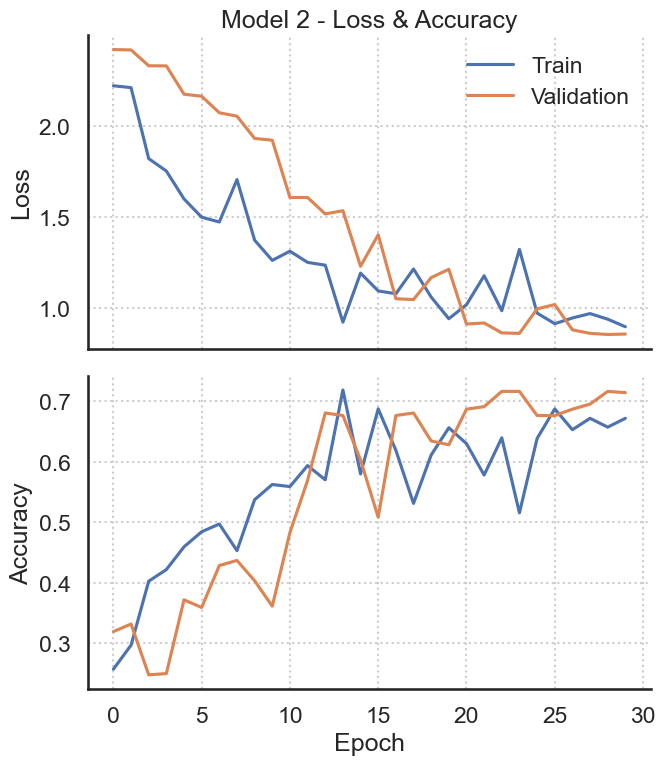

In [78]:
plot_history(history2, metric=chosen_metric, name1 = 'loss', model_name='2')

**Evaluate the model on test data**

In [79]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)  # Complete the code to evaluate the model on test data

15/15 - 0s - 7ms/step - accuracy: 0.6905 - loss: 0.9258


**Plotting the Confusion Matrix**

In [80]:
# Complete the code to obtain the output probabilities
y_test_pred=model2.predict(X_test_normalized)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [81]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_test_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# # Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
# confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)     # Complete the code to obatin the confusion matrix
# f, ax = plt.subplots(figsize=(12, 12))
# sns.heatmap(
#     confusion_matrix,
#     annot=True,
#     linewidths=.4,
#     fmt="d",
#     square=True,
#     ax=ax
# )
# # Setting the labels to both the axes
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
# ax.set_title('Confusion Matrix');
# ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
# ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
# plt.show()

**Plotting Classification Report**

In [82]:
# # Plotting the classification report
# cr=metrics.classification_report(_______,_______)     # Complete the code to plot the classification report
# print(cr)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


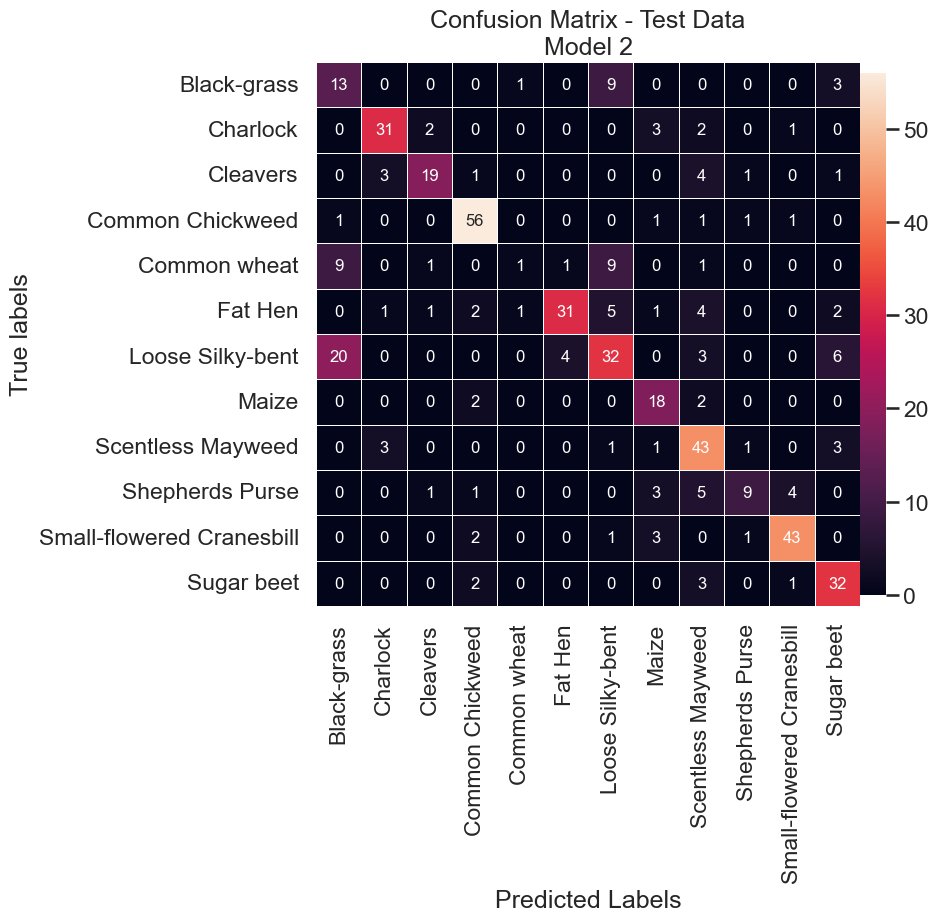

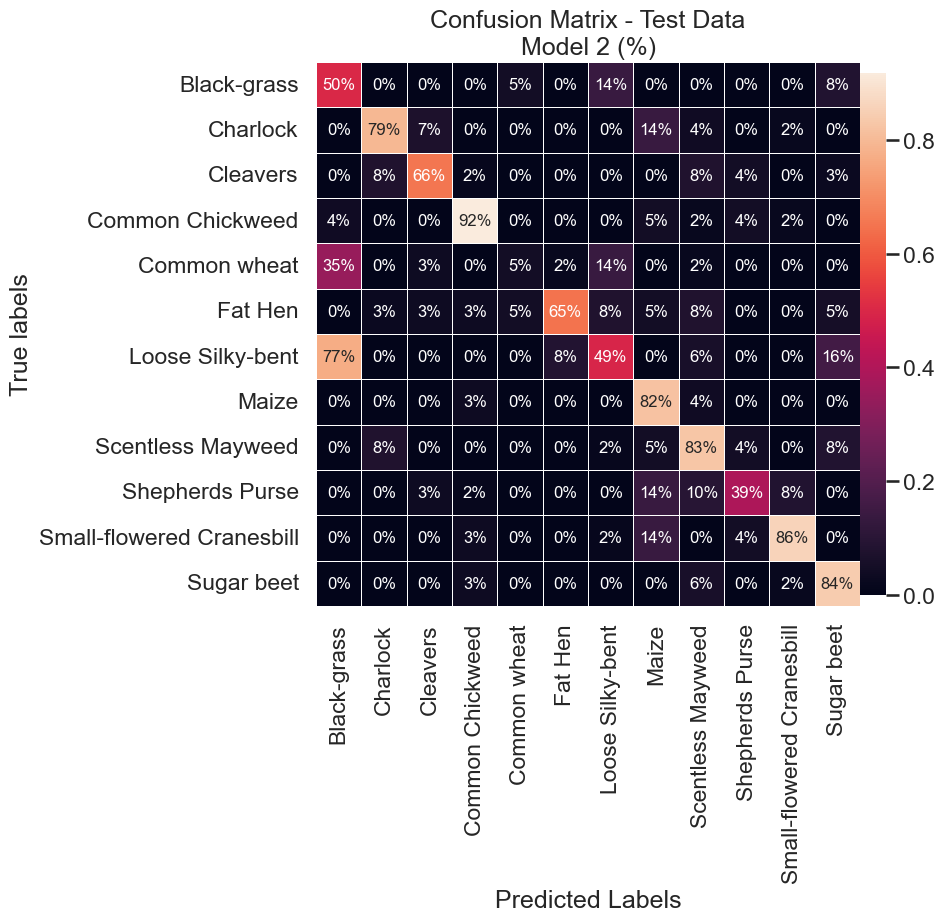

Classification Report (Test Data) - Model 2         \
                                                            precision recall   
Black-grass                                                     0.302  0.500   
Charlock                                                        0.816  0.795   
Cleavers                                                        0.792  0.655   
Common Chickweed                                                0.848  0.918   
Common wheat                                                    0.333  0.045   
Fat Hen                                                         0.861  0.646   
Loose Silky-bent                                                0.561  0.492   
Maize                                                           0.600  0.818   
Scentless Mayweed                                               0.632  0.827   
Shepherds Purse                                                 0.692  0.391   
Small-flowered Cranesbill                                       0.860  0.860   
Sugar beet                                                      0.681  0.842   
                                                                               
                                                                               
                                                                               
accuracy                                                                       
macro avg                                                       0.665  0.649   
weighted avg                                                    0.696  0.691   

                                            
                          f1-score support  
Black-grass                  0.377      26  
Charlock                     0.805      39  
Cleavers                     0.717      29  
Common Chickweed             0.882      61  
Common wheat                 0.080      22  
Fat Hen                      0.738      48  
Loose Silky-bent             0.525      65  
Maize                        0.692      22  
Scentless Mayweed            0.717      52  
Shepherds Purse              0.500      23  
Small-flowered Cranesbill    0.860      50  
Sugar beet                   0.753      38  
                                            
                                            
                                            
accuracy                     0.691          
macro avg                    0.637     475  
weighted avg                 0.679     475

In [83]:
y_test_pred_encoded = model2.predict(X_test_normalized)
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_test_pred_encoded, axis=1)
y_test_arg = np.argmax(y_test_encoded, axis=1)
plot_confusion_matrix(y_test_arg, y_pred_arg, model_name='2')
plot_confusion_matrix(y_test_arg, y_pred_arg, model_name='2', normalize=True)
report_df2 = show_classification_report(y_test_arg, y_pred_arg, model_name='2')

The precision values for Model 2 is greater than that of Model expect for Black-grass, Charlock, Loose Silky-bent, Maize, Shepherds Purse.
The recall values for Model 2 is greater than that of Model expect for Common Chickweed, Common wheat, Fat Hen, Loose Silky-bent, Small-flowered Cranesbill.
The f1-score values for Model 2 is greater than that of Model expect for Charlock, Common wheat, Loose Silky-bent, Maize, Small-flowered Cranesbill.


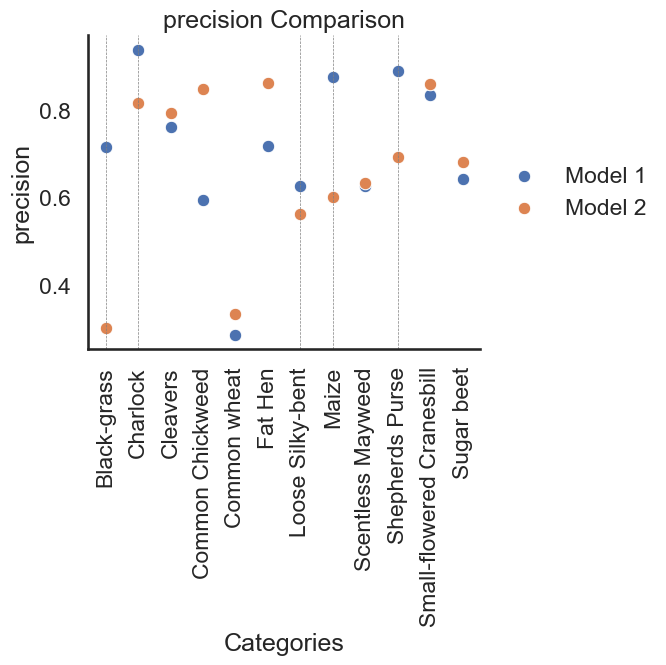

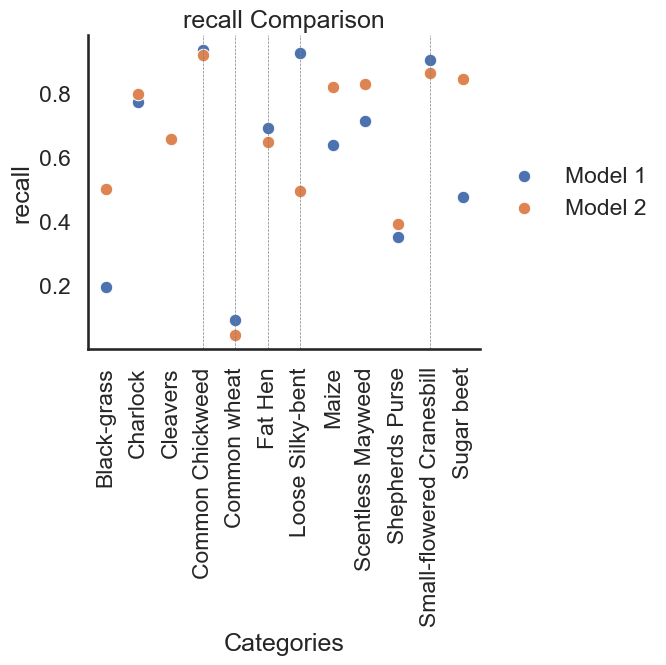

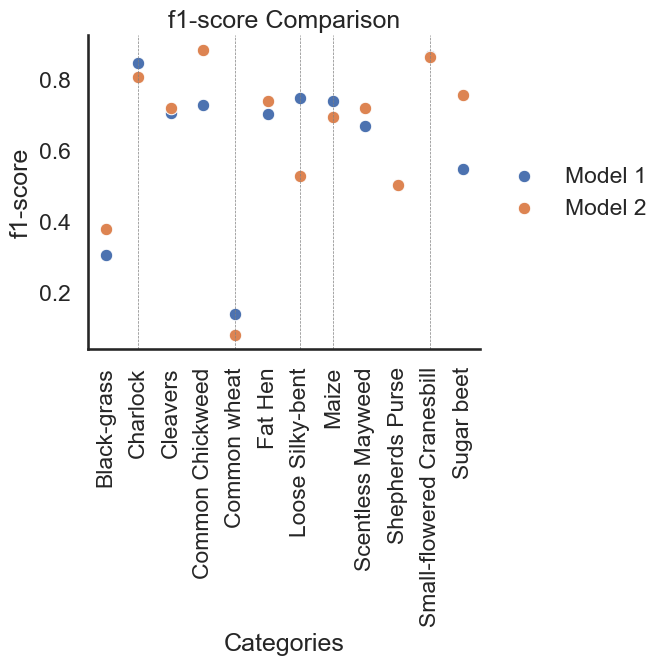

In [85]:
for col in ['precision', 'recall', 'f1-score']:
  plt.figure(figsize=(7,7))
  y1 = report_df1[col]
  y2 = report_df2[col]
  y1_greater_than_y2 = report_df1[y1>y2]
  x_y1_greater_than_y2 = y1_greater_than_y2.index.tolist()
  x_y1_greater_than_y2_str = list(map(str, x_y1_greater_than_y2))
  print(f"The {col} values for Model 2 is greater than that of Model expect for {', '.join(x_y1_greater_than_y2_str)}.")
  sns.scatterplot(data=report_df1, x=report_df1.index, y=col, label='Model 1')
  sns.scatterplot(data=report_df2, x=report_df2.index, y=col, label='Model 2')
  sns.despine()
  plt.xticks(rotation=90)  # You can change the angle as needed
  plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
  for x in x_y1_greater_than_y2:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=.5)
  plt.title(f'{col} Comparison')
  plt.tight_layout()
  plt.savefig(f"{image_dir}/model_comparison_{col}.png", bbox_inches='tight')

In [86]:
list(map(str, x_y1_greater_than_y2))

['Charlock',
 'Common wheat',
 'Loose Silky-bent',
 'Maize',
 'Small-flowered Cranesbill']

In [87]:
report_df1
report_df2

precision  recall  f1-score  support
Categories                                                     
Black-grass                    0.302   0.500     0.377     26.0
Charlock                       0.816   0.795     0.805     39.0
Cleavers                       0.792   0.655     0.717     29.0
Common Chickweed               0.848   0.918     0.882     61.0
Common wheat                   0.333   0.045     0.080     22.0
Fat Hen                        0.861   0.646     0.738     48.0
Loose Silky-bent               0.561   0.492     0.525     65.0
Maize                          0.600   0.818     0.692     22.0
Scentless Mayweed              0.632   0.827     0.717     52.0
Shepherds Purse                0.692   0.391     0.500     23.0
Small-flowered Cranesbill      0.860   0.860     0.860     50.0
Sugar beet                     0.681   0.842     0.753     38.0

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

### Visualizing the prediction

In [88]:
df1 = pd.DataFrame(info1, index=['Model 1'])
df2 = pd.DataFrame(info2, index=['Model 2'])
compare_df = pd.concat([df1, df2]).drop(columns=['Layers']).T

In [89]:
compare_df.shape[0]

24

In [90]:
sub_different = compare_df[compare_df['Model 1']!=compare_df['Model 2']]
sub_different = pd.concat([sub_different.loc['# Trainable Params':'Learning Rate'], sub_different.loc['Elapsed Time (s)':]])
sub_different['']=''
sub_different.loc['# Trainable Params', ''] = 'Model 2 has more parameters to train.'
sub_different.loc['Batch Size', ''] = 'Model 2 has a higher batch size.'
sub_different.loc['Augmentation (Rotation)', ''] = 'The image for training Model 2 are rotated.'
sub_different.loc['Learning Rate Reduction', ''] = 'Model 2 is trained with learning rate reduction.'
sub_different.loc['Steps per Epoch', ''] = 'Model 2 has a lower number of steps per epoch.'
sub_different.loc['Normalization Layer', ''] = 'Model 2 uses batch normalization.'
sub_different.loc['Learning Rate', ''] = 'Model 2 optimizer uses a lower learning rate.'
sub_different.loc['Elapsed Time (s)', ''] = 'Model 2 takes longer to train.'
sub_different.index.name = 'Parameter Comparison'
display(sub_different)

Model 1              Model 2  \
Parameter Comparison                                             
# Trainable Params                128,828              151,612   
Batch Size                             32                   64   
Augmentation (Rotation)                 0                   20   
Learning Rate Reduction                      ReduceLROnPlateau   
Steps per Epoch                       119                   59   
# Conv2D Layers                         3                    2   
# MaxPooling2D Layers                   3                    2   
Normalization Layer                        batch normalization   
# Filters (Conv)              128, 64, 32               64, 32   
Activation (Conv)        relu, relu, relu           relu, relu   
Learning Rate                       0.001               0.0001   
Elapsed Time (s)                   163.73                37.35   

                                                                           
Parameter Comparison                                                       
# Trainable Params                  Model 2 has more parameters to train.  
Batch Size                               Model 2 has a higher batch size.  
Augmentation (Rotation)       The image for training Model 2 are rotated.  
Learning Rate Reduction  Model 2 is trained with learning rate reduction.  
Steps per Epoch            Model 2 has a lower number of steps per epoch.  
# Conv2D Layers                                                            
# MaxPooling2D Layers                                                      
Normalization Layer                     Model 2 uses batch normalization.  
# Filters (Conv)                                                           
Activation (Conv)                                                          
Learning Rate               Model 2 optimizer uses a lower learning rate.  
Elapsed Time (s)                           Model 2 takes longer to train.

In [91]:
display(compare_df.iloc[:compare_df.shape[0]//2])
display(compare_df.iloc[compare_df.shape[0]//2:])

Model 1              Model 2
# Trainable Params           128,828              151,612
Epochs                            30                   30
Batch Size                        32                   64
Augmentation (Rotation)            0                   20
Learning Rate Reduction                 ReduceLROnPlateau
Steps per Epoch                  119                   59
# Conv2D Layers                    3                    2
# MaxPooling2D Layers              3                    2
# Dropout Layers                   1                    1
Normalization Layer                   batch normalization
# Neurons (Dense)             16, 12               16, 12
# Filters (Conv)         128, 64, 32               64, 32

Model 1        Model 2
Activation (Dense)      relu, softmax  relu, softmax
Activation (Conv)    relu, relu, relu     relu, relu
Optimizer                        adam           adam
Learning Rate                   0.001         0.0001
Regularization           Dropout(0.3)   Dropout(0.3)
Train Loss                     0.9925         0.8989
Validation Loss                1.0425         0.8587
Train Accuracy                  0.634          0.672
Validation Accuracy             0.702          0.714
Test Loss                       1.091          0.926
Test Accuracy                   0.691          0.691
Elapsed Time (s)               163.73          37.35

In [92]:
sub_compare = compare_df.loc['Train Loss': 'Test Accuracy']
sub_compare.loc['| Train Loss - Validation Loss |'] = abs(sub_compare.loc['Train Loss'] - sub_compare.loc['Validation Loss'])


sub_compare = sub_compare.loc[['Train Loss', 'Validation Loss', 'Train Accuracy',
                 'Validation Accuracy', '| Train Loss - Validation Loss |', 'Test Loss', 'Test Accuracy']]
sub_compare[''] = ''
sub_compare.loc['Train Accuracy', ''] = 'Model 2 has a higher train accuracy.'
sub_compare.loc['Validation Accuracy', ''] = 'Model 2 has a higher validation accuracy.'
sub_compare.loc['| Train Loss - Validation Loss |', ''] = 'Model 2 has a smaller absolute loss difference.'
display(sub_compare)

Model 1 Model 2  \
Train Loss                        0.9925  0.8989   
Validation Loss                   1.0425  0.8587   
Train Accuracy                     0.634   0.672   
Validation Accuracy                0.702   0.714   
| Train Loss - Validation Loss |    0.05  0.0402   
Test Loss                          1.091   0.926   
Test Accuracy                      0.691   0.691   

                                                                                   
Train Loss                                                                         
Validation Loss                                                                    
Train Accuracy                               Model 2 has a higher train accuracy.  
Validation Accuracy                     Model 2 has a higher validation accuracy.  
| Train Loss - Validation Loss |  Model 2 has a smaller absolute loss difference.  
Test Loss                                                                          
Test Accuracy

In [93]:
model = model2

In [94]:
y_test_pred=model.predict(X_test_normalized)
y_pred_arg=np.argmax(y_test_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [95]:
true_pred_test_df = pd.DataFrame({'True': y_test_arg, 'Pred': y_pred_arg}, index = y_test.index)
true_pred_test_df['correct'] = true_pred_test_df['True'] == true_pred_test_df['Pred']
true_pred_test_df.reset_index(inplace=True)
true_pred_test_df.index.name = 'ind'
true_pred_test_df

index  True  Pred  correct
ind                            
0     1565     3     3     True
1      410    10    10     True
2      221    10    10     True
3       53    10    10     True
4     2379     1     1     True
..     ...   ...   ...      ...
470    433    10     3    False
471   2695     2     2     True
472   4673     6     0    False
473   3035     8     8     True
474   1075     9     9     True

[475 rows x 4 columns]

In [96]:
sampled_correct_df = true_pred_test_df[true_pred_test_df['correct']==True].groupby('True').apply(lambda x: x.sample(1))
new_names = list(sampled_correct_df.index.names)
new_names[0] = 'to_drop'  # rename first index level
sampled_correct_df.index.set_names(new_names, inplace=True)
sampled_correct_df = sampled_correct_df.reset_index().set_index('ind')
sampled_correct_df.drop(columns=['to_drop'], inplace=True)
display(sampled_correct_df)


sampled_incorrect_df = true_pred_test_df[true_pred_test_df['correct']==False].groupby('True').apply(lambda x: x.sample(1))
new_names = list(sampled_incorrect_df.index.names)
new_names[0] = 'to_drop'  # rename first index level
sampled_incorrect_df.index.set_names(new_names, inplace=True)
sampled_incorrect_df = sampled_incorrect_df.reset_index().set_index('ind')
sampled_incorrect_df.drop(columns=['to_drop'], inplace=True)
display(sampled_incorrect_df)

index  True  Pred  correct
ind                            
65    3834     0     0     True
57    2266     1     1     True
195   2435     2     2     True
206   1559     3     3     True
171   1268     4     4     True
103    579     5     5     True
27    4406     6     6     True
153   3662     7     7     True
412   2978     8     8     True
30    1184     9     9     True
469    222    10    10     True
6     3596    11    11     True

index  True  Pred  correct
ind                            
34    3920     0    11    False
149   2417     1     2    False
464   2635     2     1    False
426   1969     3     9    False
404   1282     4     6    False
143    911     5     3    False
32    4244     6    11    False
84    3778     7     8    False
144   2965     8    11    False
97    1063     9     8    False
463    389    10     9    False
360   3438    11     8    False

In [97]:
arr = [2, 33, 59, 36]
correct_arr = sampled_correct_df.index[-5:]
incorrect_arr = sampled_incorrect_df.index[-5:]
arr = list(map(int, list(np.concatenate([correct_arr, incorrect_arr]))))
image_dict = {}
for ind in arr:
  predicted_label = enc.inverse_transform(model.predict((X_test_normalized[ind].reshape(1,64,64,3))))[0]
  true_label = enc.inverse_transform(y_test_encoded)[ind]
  image_dict.update({ind: {'image': X_test[ind], 'Predicted': predicted_label, 'True': true_label}})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [98]:
true_pred_test_df

index  True  Pred  correct
ind                            
0     1565     3     3     True
1      410    10    10     True
2      221    10    10     True
3       53    10    10     True
4     2379     1     1     True
..     ...   ...   ...      ...
470    433    10     3    False
471   2695     2     2     True
472   4673     6     0    False
473   3035     8     8     True
474   1075     9     9     True

[475 rows x 4 columns]

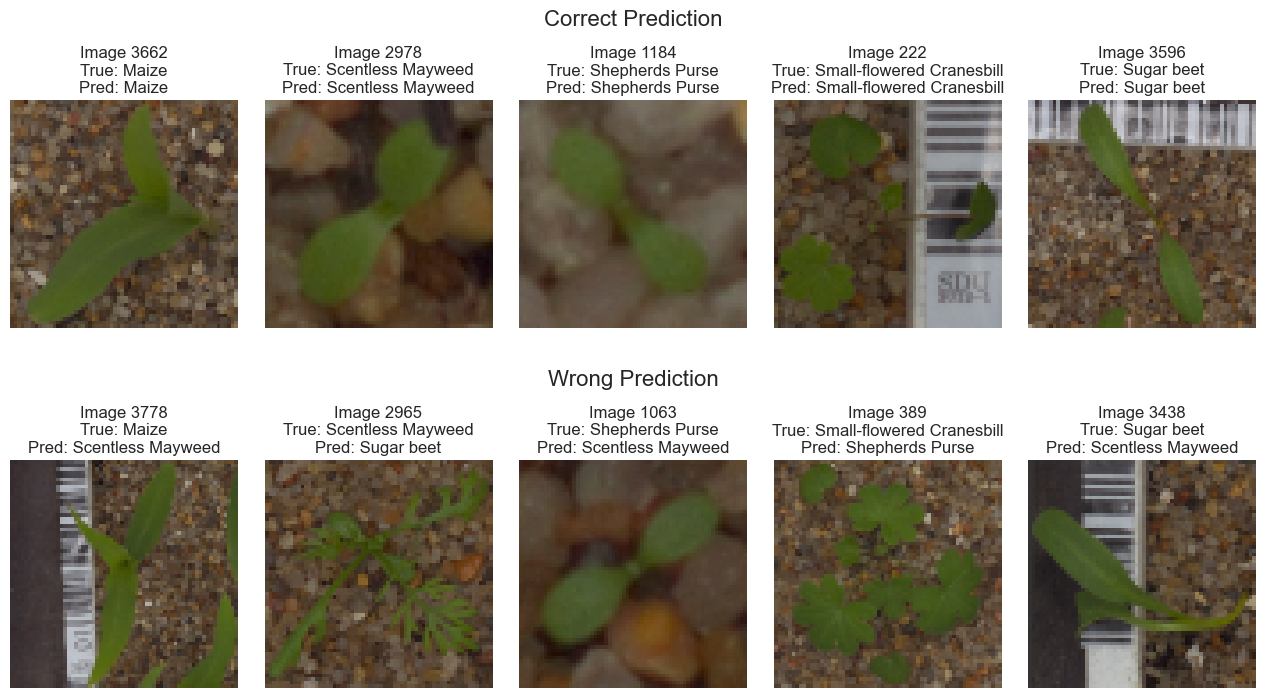

In [99]:
fig, axes = plt.subplots(2, len(image_dict)//2, figsize=(13, 8))
axes = axes.flatten()
c = 0
for i, imdict in image_dict.items():
  image = imdict['image']
  pred = imdict['Predicted']
  true = imdict['True']
  try:
    axes[c].imshow(image)
    real_index = true_pred_test_df.loc[i]['index']
    title = f'Image {real_index}\nTrue: {true}\nPred: {pred}'
    sns.despine(ax=axes[c])
    axes[c].axis('off')
    axes[c].set_title(title, fontsize=12)
  except Exception as e:
    print(e)
  c+=1

fig.text(0.5, 0.96, 'Correct Prediction', ha='center', fontsize=16)
fig.text(0.5, 0.51, 'Wrong Prediction', ha='center', fontsize=16)

plt.tight_layout()
# plt.show()
plt.savefig(f"{image_dir}/prediction_sample_correct_wrong.png", bbox_inches='tight')

## Actionable Insights and Business Recommendations

### Insights:
- Based on our observation, we observe that lowering the optimizer’s learning rate, adding batch
normalization, doing data augmentation, lowering the number of convolution layers and dense
layers could help improve the performance of our model and also reduce overfitting.
### Recommendations:
- Training multiple models.
- Figuring out the patterns where the models make the wrong prediction.
- Trying different combinations of convolution, max-pooling, dense, and dropout layers.
- Try different ways of regularization.
- Try different ways of augmenting the data.
- Conduct more investigation on individual classes.
- Explore different parameters on learning rate reduction.
- Investigate how steps per epochs affects the training.


_____